# LangGraph 찍먹!

LangGraph는 `에이전트` 및 `멀티에이전트 워크플로우` 를 만드는 데 사용되는 LLM으로 `상태 저장`, `멀티액터` 애플리케이션을 구축하기 위한 라이브러리입니다.

다른 LLM 프레임워크와 비교할 때 `주기(Cycle)`, `제어 가능성`, `지속성` 이라는 핵심 이점을 제공합니다. LangGraph를 사용하면 대부분의 에이전트 아키텍처에 필수적인 `주기를 포함하는 플로우를 정의할 수 있어 DAG 기반 솔루션과 차별화` 됩니다.

매우 낮은 수준의 프레임워크로서 애플리케이션의 `흐름과 상태를 모두 세밀하게 제어할 수 있어 안정적인 에이전트를 만드는 데 매우 중요` 합니다. 또한 LangGraph에는 지속성이 내장되어 있어 고급 휴먼 인 더 루프 및 메모리 기능을 사용할 수 있습니다.

LangGraph는 Pregel과 Apache Beam에서 영감을 받았습니다. 공용 인터페이스는 NetworkX에서 영감을 얻었습니다. LangGraph는 LangChain을 개발한 LangChain Inc에서 구축했지만, LangChain 없이도 사용할 수 있습니다.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_teddynote import logging
logging.langsmith("CH17-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LANGGRAPH


# 노드와 엣지
주요 개념

- `GraphState(상태 저장 그래프)`: LangGraph는 그래프의 각 노드가 계산의 단계를 나타내며, 그래프는 계산이 진행됨에 따라 전달되고 업데이트되는 상태를 유지하는 상태 저장 그래프 개념을 중심으로 작동합니다.
- `Node(노드)`: 노드는 LangGraph의 구성 요소입니다. 각 노드는 함수 또는 계산 단계를 나타냅니다. 입력 처리, 의사 결정, 외부 API와의 상호 작용 등 특정 작업을 수행하도록 노드를 정의할 수 있습니다.
- `Edge(엣지)`: 에지는 그래프에서 노드를 연결하여 계산의 흐름을 정의합니다. LangGraph는 조건부 에지를 지원하므로 그래프의 현재 상태에 따라 실행할 다음 노드를 동적으로 결정할 수 있습니다.

# StateGraph
각 노드에서 다음 노드로 전달되는 상태를 저장

In [3]:
from typing import TypedDict

class GraphState(TypedDict):
    goal: str # 목표
    todo: list[str] # 할 일 목록
    current_job: str # 현재 작업
    total_time: int # 총 소요 시간
    time_spent: int # 소요시간
    status: str # 상태

# Node & Edge

In [4]:
# 목표 설정 node
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import CommaSeparatedListOutputParser
from rag.utils import format_task

def create_todo_list(goal):
    output_parser = CommaSeparatedListOutputParser()
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "당신은 나의 할일을 관리하는 비서입니다. 당신의 임무는 나를 위하여 주어진 목표에 대하여 할일 목록을 작성하는 것입니다.",
            ),
            (
                "human",
                """주어진 목표(goal)를 잘 수행하기 위하여 할일 목록을 작성해 주세요. 
                `할일:걸리는시간(hour)` 으로 작성하세요. 걸리는 시간은 반올림하여 int 로 작성하세요.
                
                #목표: {goal}
                
                #형식: {format_instuctions}
                
                """
            )
        ]
    )
    prompt = prompt.partial(format_instuctions = output_parser.get_format_instructions())
    llm = ChatOpenAI(model="gpt-4o-mini")
    chain = prompt | llm | CommaSeparatedListOutputParser()

    output = chain.invoke({"goal": goal})
    return output

In [5]:
todo = create_todo_list("LangChain 튜토리얼로 RAG 공부하기")
todo

['튜토리얼 자료 찾기:2',
 '튜토리얼 읽기:4',
 '실습 환경 설정:1',
 '예제 코드 실행:3',
 'RAG 개념 정리:2',
 '추가 자료 검색:2']

### 각 노드의 세부 기능 정의

In [6]:
# GraphState에서의 todo를 만들어주는 함수.
def list_todo(state: GraphState) -> GraphState:
    goal = state["goal"]

    # list작성 - 목표설정
    todo = create_todo_list(goal)
    
    # 할일 목록을 포럼 - task와 시간을 나눔
    todo = format_task(create_todo_list(todo))
    return GraphState(todo=todo)

In [7]:
# 처음 시작. list todo에서 정의한 todo를 가져온다.
# pop() : # 리스트의 맨 마지막 요소를 리턴하고, 해당 요소는 삭제한다.. 따라서 pop(0)은 첫번째 요소를 리턴하고 제거한다.
def start_job(state: GraphState) -> GraphState:
    todo = state["todo"]
    if len(todo):
        current_job, total_time = todo.pop(0)
        status = "진행중"
        time_spent = 0
    return GraphState(
        current_job=current_job,
        total_time=total_time,
        status=status,
        time_spent=time_spent
    )

In [8]:
# 진행중
def process_job(state: GraphState) -> GraphState:
    time_spent = state["time_spent"]
    time_spent += 1

    return GraphState(time_spent=time_spent)

In [9]:
# 작업상태
def check_progress(state: GraphState) -> GraphState:
    if state["time_spent"] >= state["total_time"]:
        status = "다음 작업"
        if len(state["todo"]) == 0:
            status = "종료"
    else:
        status = "진행중"
    return GraphState(status=status)

In [10]:
# 다음 스텝
def next_step(state: GraphState) -> GraphState:
    return state["status"]

# 그래프 정의

In [17]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# GraphState는 위에서 class로 정의함
workflow = StateGraph(GraphState)

# todo를 작성
workflow.add_node("list_todo", list_todo)

# todo 작업 시작
workflow.add_node("start_job", start_job)

# 작업을 진행
workflow.add_node("process_job", process_job)

# 작업을 중간에 체크
workflow.add_node("check_progress", check_progress)

# 각 노드들을 연결
workflow.add_edge("list_todo", "start_job")
workflow.add_edge("start_job", "process_job")
workflow.add_edge("process_job", "check_progress")

# 조건부 edge
workflow.add_conditional_edges(
    "check_progress",
    next_step,
    {
        "진행중" : "process_job",
        "다음 작업": "start_job",
        "종료": END
    }
)

# 시작접을 설정
workflow.set_entry_point("list_todo")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

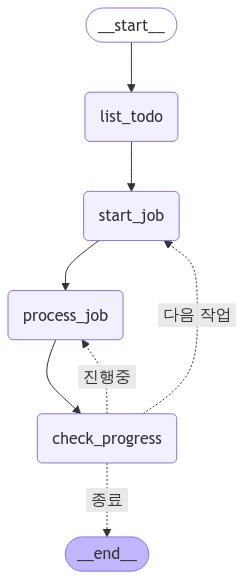

In [18]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
       # xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [19]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "TODO"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(goal="랭체인(LangChain) 밋업에서 발표자료를 준비하기")

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"[NODE] {key}")
            for k, v in value.items():
                pprint.pprint(f"<{k}> {v}")
            pprint.pprint("===" * 10)
            # 출력 값을 예쁘게 출력합니다.
            # pprint.pprint(value, indent=2, width=80, depth=None)
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

'[NODE] list_todo'
("<todo> [('자료 조사', 3), ('발표자료 구성', 2), ('슬라이드 디자인', 4), ('리허설', 2), ('피드백 "
 "반영', 1), ('최종 점검', 1)]")
'=============================='
'[NODE] start_job'
'<current_job> 자료 조사'
'<total_time> 3'
'<time_spent> 0'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 1'
'=============================='
'[NODE] check_progress'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 2'
'=============================='
'[NODE] check_progress'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 3'
'=============================='
'[NODE] check_progress'
'<status> 다음 작업'
'=============================='
'[NODE] start_job'
'<current_job> 발표자료 구성'
'<total_time> 2'
'<time_spent> 0'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 1'
'=============================='
'[NODE] check_progress'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'